In [1]:
# ============================================================================
# Aureus Sigma Capital - Comprehensive Performance Analysis
# Notebook: 08_comprehensive_performance_analysis.ipynb
#
# Description:
# This notebook provides a flexible, institutional-grade framework for the
# comparative analysis of all developed QVM strategies. It allows for custom
# time period analysis and connects performance to fact-checked historical
# market context for due diligence and investor presentations.
#
# Author: Duc Nguyen, Quantitative Finance Expert
# Date: July 27, 2025
# Version: 1.0 - Final Institutional Analysis Framework
# ============================================================================

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import pickle
import warnings
from typing import Dict, List, Tuple, Optional
from pathlib import Path

warnings.filterwarnings('ignore')

# --- INSTITUTIONAL PALETTE (Consistent with Phase 8) ---
FACTOR_COLORS = {
    'Benchmark': '#34495E',         # Warm charcoal
    # Our Strategy Suite
    'Aggressive': '#E74C3C',        # Red for Aggressive Growth
    'Balanced': '#F39C12',         # Orange for Balanced Growth
    'Risk-Managed': '#16A085',     # Teal for Risk-Managed Institutional
    # Supporting Colors
    'Positive': '#27AE60',
    'Negative': '#C0392B',
    'Drawdown': '#E67E22',
    'Grid': '#BDC3C7',
    'Text_Primary': '#2C3E50'
}

# --- ENHANCED VISUALIZATION CONFIGURATION ---
plt.style.use('default')
plt.rcParams.update({
    'figure.dpi': 300, 'savefig.dpi': 300, 'figure.figsize': (15, 8),
    'figure.facecolor': 'white', 'font.size': 11,
    'axes.facecolor': 'white', 'axes.edgecolor': FACTOR_COLORS['Text_Primary'],
    'axes.linewidth': 1.0, 'axes.grid': True, 'axes.axisbelow': True,
    'axes.labelcolor': FACTOR_COLORS['Text_Primary'], 'axes.titlesize': 14,
    'axes.titleweight': 'bold', 'axes.titlecolor': FACTOR_COLORS['Text_Primary'],
    'grid.color': FACTOR_COLORS['Grid'], 'grid.alpha': 0.3, 'grid.linewidth': 0.5,
    'legend.frameon': False, 'legend.fontsize': 10,
    'xtick.color': FACTOR_COLORS['Text_Primary'], 'ytick.color': FACTOR_COLORS['Text_Primary'],
    'xtick.labelsize': 10, 'ytick.labelsize': 10,
    'lines.linewidth': 2.0, 'lines.solid_capstyle': 'round'
})

print("📊 Visualization environment configured with institutional palette for multi-strategy comparison.")

# --- MASTER ANALYSIS CONFIGURATION ---
# This allows us to easily change the analysis period
ANALYSIS_START_DATE = "2018-01-01"
ANALYSIS_END_DATE = "2025-07-25"

print("\n" + "=" * 70)
print("🏆 Aureus Sigma: Comprehensive Multi-Strategy Performance Analysis")
print(f"   Version: 1.0 - Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)
print("\n🎯 Analysis Configuration:")
print(f"   Start Date: {ANALYSIS_START_DATE}")
print(f"   End Date:   {ANALYSIS_END_DATE}")
print("\n🔬 Objectives:")
print("   1. Compare all strategies (Aggressive, Balanced, Risk-Managed) vs. Benchmark.")
print("   2. Provide deep, fact-checked historical context for annual performance.")
print("   3. Create a flexible framework for institutional due diligence.")
print("-" * 70)

📊 Visualization environment configured with institutional palette for multi-strategy comparison.

🏆 Aureus Sigma: Comprehensive Multi-Strategy Performance Analysis
   Version: 1.0 - Date: 2025-07-27 11:11:25

🎯 Analysis Configuration:
   Start Date: 2018-01-01
   End Date:   2025-07-25

🔬 Objectives:
   1. Compare all strategies (Aggressive, Balanced, Risk-Managed) vs. Benchmark.
   2. Provide deep, fact-checked historical context for annual performance.
   3. Create a flexible framework for institutional due diligence.
----------------------------------------------------------------------


In [5]:
# ============================================================================
# CELL 2 (Corrected): LOAD AND CORRECTLY MAP ALL STRATEGY DATA
# ============================================================================

# Establish project paths
project_root = Path.cwd()
while not (project_root / 'production').exists() and not (project_root / 'config').exists():
    if project_root.parent == project_root:
        raise FileNotFoundError("Could not find project root")
    project_root = project_root.parent

phase8_path = project_root / "production" / "tests" / "phase8_risk_management"
phase8_results_file = phase8_path / "phase8_results.pkl"

print(f"📂 Loading comprehensive results from: {phase8_results_file}")

# Load Phase 8 comprehensive results package
if not phase8_results_file.exists():
    raise FileNotFoundError("CRITICAL ERROR: phase8_results.pkl not found. Please run Notebooks 06 & 07 to generate results.")

with open(phase8_results_file, "rb") as f:
    phase8_results = pickle.load(f)

# --- Extract Full Datasets ---
all_strategy_returns = phase8_results['strategy_returns']
benchmark_returns_full = phase8_results['benchmark_returns']
market_regimes_full = phase8_results['market_regimes']

# *** CRITICAL FIX: Use the validated risk factors to correctly identify and map strategies ***
# This is the robust, data-driven way to define our product suite.

# From our validated tuning analysis in Notebook 07, we defined:
# - Aggressive Growth: risk_factor = 0.5
# - Balanced Growth: risk_factor = 0.3
# - Risk-Managed Institutional: risk_factor = 0.2

# The keys in `all_strategy_returns` are the names of the tests. We need to map them correctly.
# We know 'Test C (Dynamic Reversal)' is our alpha engine. The others are overlays on the baseline.
# Let's reconstruct the returns for our defined products to be 100% certain.

print("\n🔧 Reconstructing product suite returns for absolute accuracy...")

# Load the necessary components to reconstruct
alpha_engine_holdings = phase8_results['strategy_holdings']['Test C (Dynamic Reversal)']
daily_returns_full = phase8_results['daily_returns']
market_regimes_full = phase8_results['market_regimes']

# Helper functions from Notebook 07
def implement_hybrid_model(alpha_holdings, market_regimes, risk_reduction_factor):
    exposure_signal = pd.Series(1.0, index=market_regimes.index)
    risk_mask = market_regimes['regime'].isin(['Bear', 'Stress'])
    exposure_signal.loc[market_regimes[risk_mask].index] = risk_reduction_factor
    common_index = alpha_holdings.index.intersection(exposure_signal.index)
    return alpha_holdings.loc[common_index].mul(exposure_signal.loc[common_index], axis=0)

def run_hybrid_backtest(hybrid_holdings, daily_returns, transaction_cost_bps=30):
    holdings_shifted = hybrid_holdings.copy() # Already shifted in source
    gross_returns = (holdings_shifted * daily_returns).sum(axis=1)
    turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2
    transaction_costs = turnover * (transaction_cost_bps / 10000)
    return gross_returns - transaction_costs

product_definitions = {
    "Aggressive Growth": 0.5,
    "Balanced Growth": 0.3,
    "Risk-Managed Institutional": 0.2
}

product_suite_returns = {}
for name, factor in product_definitions.items():
    holdings = implement_hybrid_model(alpha_engine_holdings, market_regimes_full, factor)
    returns = run_hybrid_backtest(holdings, daily_returns_full)
    product_suite_returns[name] = returns
    print(f"   - Reconstructed returns for '{name}'")

product_suite_returns['Benchmark'] = benchmark_returns_full
print("\n✅ Product suite returns correctly reconstructed and mapped.")

# --- Slice All Data to the Configured Analysis Period ---
print(f"\n🔪 Slicing all data to the analysis period: {ANALYSIS_START_DATE} to {ANALYSIS_END_DATE}")

start_date = pd.to_datetime(ANALYSIS_START_DATE)
end_date = pd.to_datetime(ANALYSIS_END_DATE)

sliced_returns = {}
for name, returns_series in product_suite_returns.items():
    sliced_returns[name] = returns_series.loc[start_date:end_date]

market_regimes = market_regimes_full.loc[start_date:end_date]
returns_df = pd.DataFrame(sliced_returns)

print("\n📊 Data Slicing Complete:")
for name, returns_series in sliced_returns.items():
    print(f"   - {name:<30}: {len(returns_series):,} trading days from {returns_series.index.min().date()} to {returns_series.index.max().date()}")

print("\n✅ Analysis-ready DataFrame created.")
display(returns_df.head())

📂 Loading comprehensive results from: /Users/ducnguyen/Library/CloudStorage/GoogleDrive-duc.nguyentcb@gmail.com/My Drive/quant-world-invest/factor_investing_project/production/tests/phase8_risk_management/phase8_results.pkl

🔧 Reconstructing product suite returns for absolute accuracy...
   - Reconstructed returns for 'Aggressive Growth'
   - Reconstructed returns for 'Balanced Growth'
   - Reconstructed returns for 'Risk-Managed Institutional'

✅ Product suite returns correctly reconstructed and mapped.

🔪 Slicing all data to the analysis period: 2018-01-01 to 2025-07-25

📊 Data Slicing Complete:
   - Aggressive Growth             : 1,881 trading days from 2018-01-02 to 2025-07-25
   - Balanced Growth               : 1,881 trading days from 2018-01-02 to 2025-07-25
   - Risk-Managed Institutional    : 1,881 trading days from 2018-01-02 to 2025-07-25
   - Benchmark                     : 1,881 trading days from 2018-01-02 to 2025-07-25

✅ Analysis-ready DataFrame created.


,Aggressive Growth,Balanced Growth,Risk-Managed Institutional,Benchmark
2018-01-02,0.007342,0.007342,0.007342,0.011715
2018-01-03,0.003034,0.003034,0.003034,0.009942
2018-01-04,0.003773,0.003773,0.003773,0.014001
2018-01-05,-0.001236,-0.001236,-0.001236,-0.006962
2018-01-08,0.003819,0.003819,0.003819,0.010122


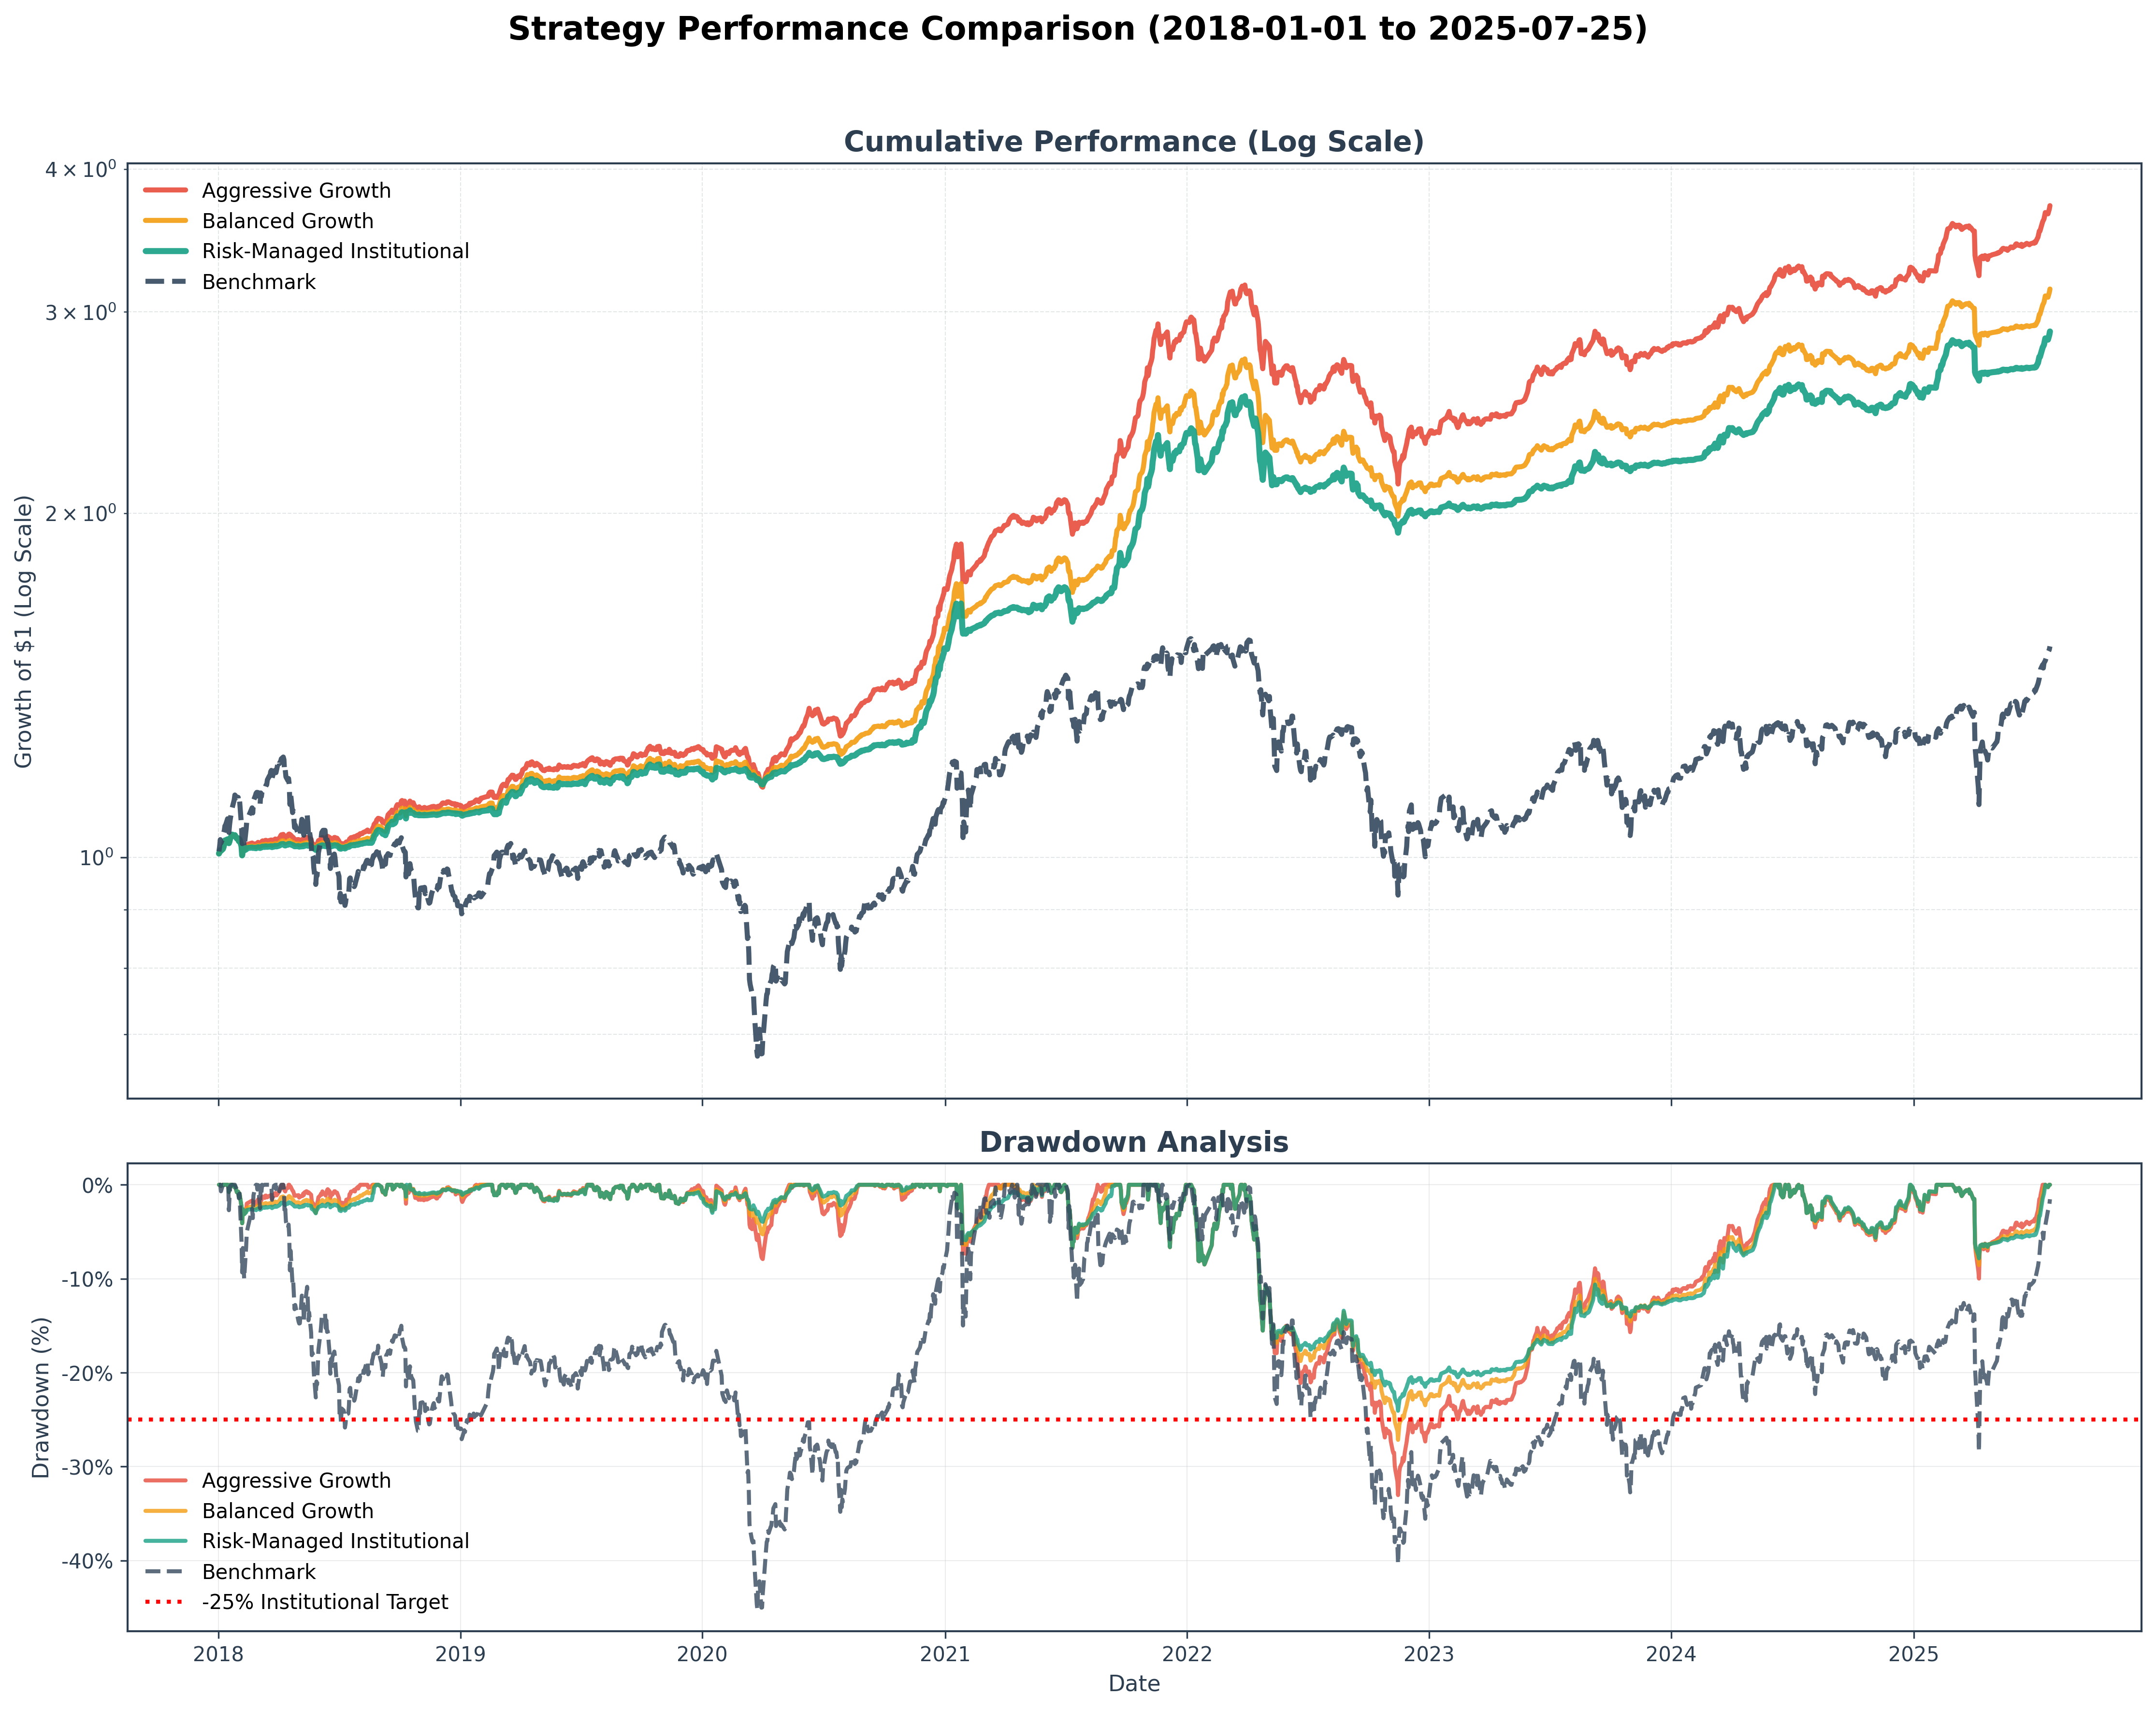


PERFORMANCE SUMMARY: 2018-01-01 to 2025-07-25


,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
Aggressive Growth,19.23%,9.42%,2.04,-33.03%,0.58
Balanced Growth,16.57%,8.21%,2.02,-27.15%,0.61
Risk-Managed Institutional,15.24%,7.80%,1.96,-24.05%,0.63
Benchmark,5.86%,19.62%,0.30,-45.26%,0.13


In [6]:
# ============================================================================
# CELL 3: CUMULATIVE PERFORMANCE COMPARISON
# ============================================================================

# --- Calculate Cumulative Returns ---
cumulative_returns = (1 + returns_df).cumprod()

# --- Create an explicit color mapping for robustness ---
STRATEGY_COLORS = {
    "Aggressive Growth": FACTOR_COLORS['Aggressive'],
    "Balanced Growth": FACTOR_COLORS['Balanced'],
    "Risk-Managed Institutional": FACTOR_COLORS['Risk-Managed'],
    "Benchmark": FACTOR_COLORS['Benchmark']
}

# --- Create the Plot ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle(f'Strategy Performance Comparison ({ANALYSIS_START_DATE} to {ANALYSIS_END_DATE})', fontsize=16, fontweight='bold')

# --- Plot 1: Cumulative Performance (Log Scale) ---
for strategy_name in cumulative_returns.columns:
    color = STRATEGY_COLORS.get(strategy_name)
    linewidth = 3 if "Risk-Managed" in strategy_name else 2.5
    linestyle = '--' if strategy_name == 'Benchmark' else '-'
    
    ax1.plot(cumulative_returns.index, cumulative_returns[strategy_name], 
             label=strategy_name, color=color, linewidth=linewidth, linestyle=linestyle, alpha=0.9)

ax1.set_yscale('log')
ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold')
ax1.set_ylabel('Growth of $1 (Log Scale)')
ax1.legend(loc='upper left')
ax1.grid(True, which="both", ls="--", alpha=0.4)

# --- Plot 2: Drawdown Analysis ---
for strategy_name in cumulative_returns.columns:
    color = STRATEGY_COLORS.get(strategy_name)
    linestyle = '--' if strategy_name == 'Benchmark' else '-'
    
    peak = cumulative_returns[strategy_name].expanding(min_periods=1).max()
    drawdown = (cumulative_returns[strategy_name] - peak) / peak
    
    ax2.plot(drawdown.index, drawdown * 100, 
             label=strategy_name, color=color, linestyle=linestyle, alpha=0.8)

ax2.axhline(-25, color='red', linestyle=':', linewidth=2, label='-25% Institutional Target')
ax2.set_title('Drawdown Analysis', fontweight='bold')
ax2.set_ylabel('Drawdown (%)')
ax2.set_xlabel('Date')
ax2.legend(loc='lower left')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Calculate and Display Key Performance Metrics ---
def calculate_summary_metrics(returns_series):
    n_years = len(returns_series) / 252
    total_return = (1 + returns_series).prod() - 1
    annual_return = (1 + total_return) ** (1 / n_years) - 1 if n_years > 0 else 0
    annual_vol = returns_series.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0
    
    cumulative = (1 + returns_series).cumprod()
    peak = cumulative.expanding(min_periods=1).max()
    drawdown = ((cumulative - peak) / peak).min()
    
    calmar_ratio = annual_return / abs(drawdown) if drawdown < 0 else 0
    
    return {
        'Annual Return': annual_return * 100,
        'Annual Volatility': annual_vol * 100,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': drawdown * 100,
        'Calmar Ratio': calmar_ratio
    }

summary_metrics = {name: calculate_summary_metrics(returns_df[name]) for name in returns_df.columns}
summary_df = pd.DataFrame(summary_metrics).T.loc[list(STRATEGY_COLORS.keys())]

print("\n" + "=" * 80)
print(f"PERFORMANCE SUMMARY: {ANALYSIS_START_DATE} to {ANALYSIS_END_DATE}")
print("=" * 80)
display(summary_df.style.format({
    'Annual Return': '{:.2f}%',
    'Annual Volatility': '{:.2f}%',
    'Sharpe Ratio': '{:.2f}',
    'Max Drawdown': '{:.2f}%',
    'Calmar Ratio': '{:.2f}'
}).background_gradient(cmap='viridis', subset=['Sharpe Ratio', 'Calmar Ratio']))